# Análisis de Correlaciones - Telecom X

## Propósito
En este cuaderno, se exploran las correlaciones entre variables numéricas y binarias del dataset, con enfoque en la relación entre `Cargos_Diarios`, la cantidad de servicios contratados (`Total_Servicios`), y `Evasión`. Se utiliza una matriz de correlación y gráficos de dispersión para identificar factores asociados con la evasión.

## Tarea
1. Cargar el dataset estandarizado desde la URL de la API y aplicar transformaciones previas.
2. Crear una variable `Total_Servicios` sumando los servicios contratados.
3. Calcular correlaciones con `corr()` de Pandas.
4. Visualizar resultados con una matriz de correlación (heatmap) y gráficos de dispersión.
5. Guardar las visualizaciones como PNG en la carpeta `img/`.
6. Interpretar los patrones observados.


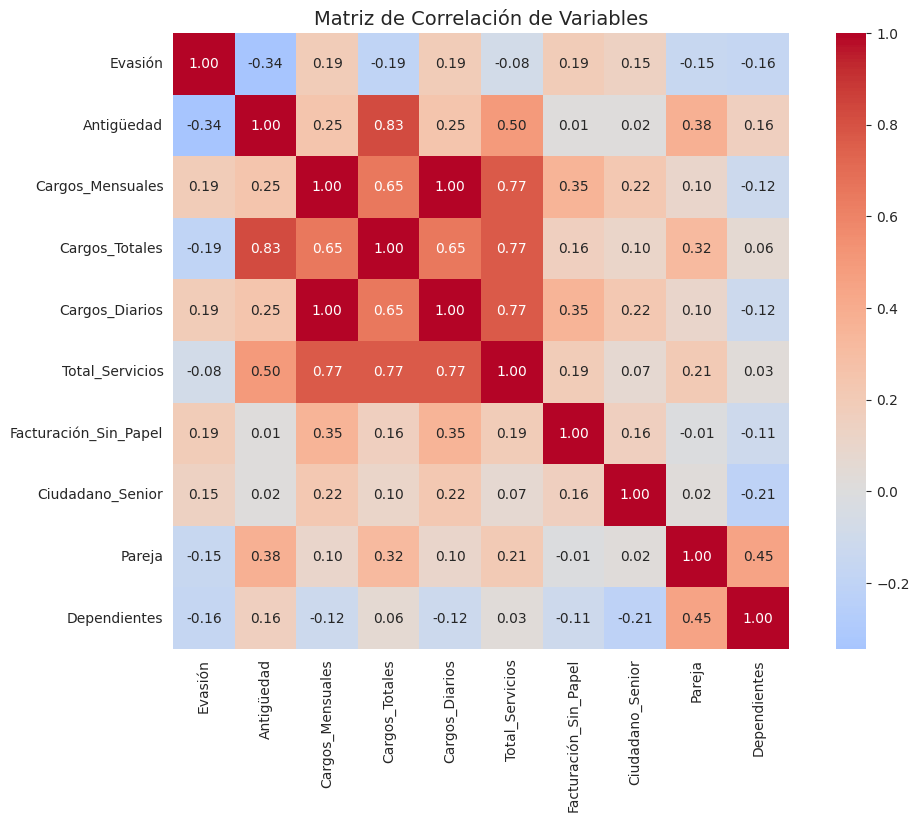

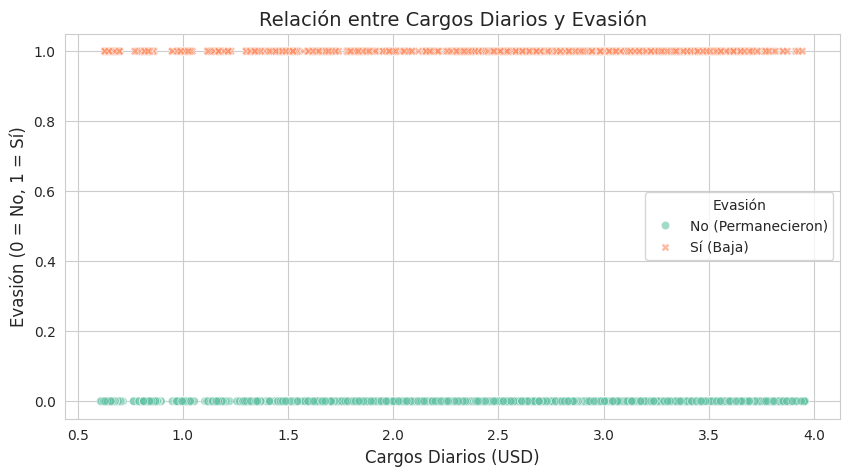

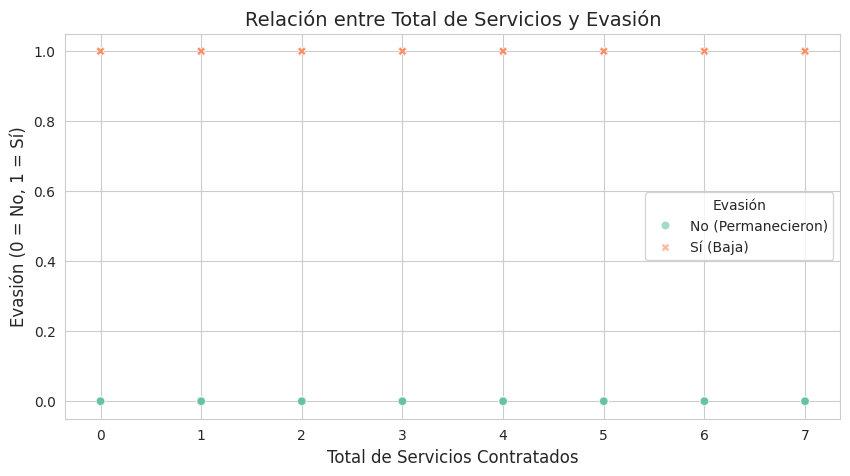


Gráficos guardados como:
- correlacion_heatmap.png
- dispersion_cargos_diarios.png
- dispersion_total_servicios.png


In [1]:
# Importación de bibliotecas
import pandas as pd
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de estilo para gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Carga de datos con manejo de errores
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
try:
    response = requests.get(url)
    response.raise_for_status()
except requests.exceptions.RequestException as e:
    print(f"Error al descargar los datos: {e}")
    raise

try:
    data = response.json()
except json.JSONDecodeError as e:
    print(f"Error al decodificar JSON: {e}")
    print("Contenido de la respuesta:", response.text[:500])
    raise

# Conversión a DataFrame
df = pd.DataFrame(data)

# Desanidar columnas JSON
customer_df = pd.json_normalize(df['customer'])
customer_df.columns = [f"customer_{col}" for col in customer_df.columns]
phone_df = pd.json_normalize(df['phone'])
phone_df.columns = [f"phone_{col}" for col in phone_df.columns]
internet_df = pd.json_normalize(df['internet'])
internet_df.columns = [f"internet_{col}" for col in internet_df.columns]
account_df = pd.json_normalize(df['account'])
account_df.columns = [f"account_{col}" for col in account_df.columns]

# Combinar los datos desanidados
df_clean = pd.concat([df[['customerID', 'Churn']], customer_df, phone_df, internet_df, account_df], axis=1)

# Aplicar correcciones previas
df_clean['Churn'] = df_clean['Churn'].replace('', 'No')
df_clean['account_Charges.Monthly'] = pd.to_numeric(df_clean['account_Charges.Monthly'], errors='coerce')
df_clean['account_Charges.Total'] = pd.to_numeric(df_clean['account_Charges.Total'], errors='coerce')
df_clean['customer_tenure'] = df_clean['customer_tenure'].astype('int64')
df_clean['customer_SeniorCitizen'] = df_clean['customer_SeniorCitizen'].astype('int64')

# Imputar valores nulos en 'account_Charges.Total'
median_total = df_clean['account_Charges.Total'].median()
df_clean['account_Charges.Total'] = df_clean.apply(
    lambda row: row['account_Charges.Monthly'] if pd.isna(row['account_Charges.Total']) and row['customer_tenure'] <= 1
    else row['account_Charges.Total'] if not pd.isna(row['account_Charges.Total'])
    else median_total,
    axis=1
)

# Crear la columna 'Cuentas_Diarias'
df_clean['Cuentas_Diarias'] = df_clean['account_Charges.Monthly'] / 30

# Estandarizar variables binarias
binary_columns = [
    'Churn', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService',
    'account_PaperlessBilling', 'internet_OnlineSecurity', 'internet_OnlineBackup',
    'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV',
    'internet_StreamingMovies'
]
for col in binary_columns:
    df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0})

# Renombrar columnas
column_mapping = {
    'customerID': 'ID_Cliente', 'Churn': 'Evasión', 'customer_gender': 'Género',
    'customer_SeniorCitizen': 'Ciudadano_Senior', 'customer_Partner': 'Pareja',
    'customer_Dependents': 'Dependientes', 'customer_tenure': 'Antigüedad',
    'phone_PhoneService': 'Servicio_Telefónico', 'phone_MultipleLines': 'Líneas_Múltiples',
    'internet_InternetService': 'Servicio_Internet', 'internet_OnlineSecurity': 'Seguridad_Online',
    'internet_OnlineBackup': 'Respaldo_Online', 'internet_DeviceProtection': 'Protección_Dispositivo',
    'internet_TechSupport': 'Soporte_Técnico', 'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Películas', 'account_Contract': 'Contrato',
    'account_PaperlessBilling': 'Facturación_Sin_Papel', 'account_PaymentMethod': 'Método_Pago',
    'account_Charges.Monthly': 'Cargos_Mensuales', 'account_Charges.Total': 'Cargos_Totales',
    'Cuentas_Diarias': 'Cargos_Diarios'
}
df_clean = df_clean.rename(columns=column_mapping)

# Crear variable 'Total_Servicios'
service_columns = [
    'Servicio_Telefónico', 'Seguridad_Online', 'Respaldo_Online',
    'Protección_Dispositivo', 'Soporte_Técnico', 'Streaming_TV', 'Streaming_Películas'
]
df_clean['Total_Servicios'] = df_clean[service_columns].sum(axis=1)

# Seleccionar variables para correlación
corr_vars = [
    'Evasión', 'Antigüedad', 'Cargos_Mensuales', 'Cargos_Totales', 'Cargos_Diarios',
    'Total_Servicios', 'Facturación_Sin_Papel', 'Ciudadano_Senior', 'Pareja', 'Dependientes'
]

# Calcular matriz de correlación
corr_matrix = df_clean[corr_vars].corr()

# 1. Matriz de correlación (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Matriz de Correlación de Variables', fontsize=14)
plt.savefig('correlacion_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 2. Gráfico de dispersión: Cargos_Diarios vs. Evasión
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Cargos_Diarios', y='Evasión', hue='Evasión_Etiqueta', style='Evasión_Etiqueta',
                data=df_clean.assign(Evasión_Etiqueta=df_clean['Evasión'].map({0: 'No (Permanecieron)', 1: 'Sí (Baja)'})),
                palette='Set2', alpha=0.6)
plt.title('Relación entre Cargos Diarios y Evasión', fontsize=14)
plt.xlabel('Cargos Diarios (USD)', fontsize=12)
plt.ylabel('Evasión (0 = No, 1 = Sí)', fontsize=12)
plt.legend(title='Evasión')
plt.savefig('dispersion_cargos_diarios.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 3. Gráfico de dispersión: Total_Servicios vs. Evasión
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Total_Servicios', y='Evasión', hue='Evasión_Etiqueta', style='Evasión_Etiqueta',
                data=df_clean.assign(Evasión_Etiqueta=df_clean['Evasión'].map({0: 'No (Permanecieron)', 1: 'Sí (Baja)'})),
                palette='Set2', alpha=0.6)
plt.title('Relación entre Total de Servicios y Evasión', fontsize=14)
plt.xlabel('Total de Servicios Contratados', fontsize=12)
plt.ylabel('Evasión (0 = No, 1 = Sí)', fontsize=12)
plt.legend(title='Evasión')
plt.savefig('dispersion_total_servicios.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 4. Confirmación de guardado
print("\nGráficos guardados como:")
print("- correlacion_heatmap.png")
print("- dispersion_cargos_diarios.png")
print("- dispersion_total_servicios.png")

## Descripción de la tarea
En esta sección, se analizaron las correlaciones entre variables numéricas (`Antigüedad`, `Cargos_Mensuales`, `Cargos_Totales`, `Cargos_Diarios`, `Total_Servicios`) y binarias (`Evasión`, `Facturación_Sin_Papel`, `Ciudadano_Senior`, `Pareja`, `Dependientes`). Se creó la variable `Total_Servicios` sumando los servicios contratados. Los resultados se visualizaron con una matriz de correlación (heatmap) y gráficos de dispersión para `Cargos_Diarios` y `Total_Servicios` vs. `Evasión`. Las visualizaciones se guardaron en `img/` como PNG.